In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
%cd /content/drive/MyDrive/FundamentalLearningEPFL/Homeworks/HW3

/content/drive/MyDrive/FundamentalLearningEPFL/Homeworks/HW3


# $\color{Green}{\text{Fundamentals of Inference and Learning}}$
Name: Roduit \
Surname : Vincent \
Sciper: 325140

Again, as said in Homework 1, only relevant steps of the calculation are written in this notebook. The full derivation can be found in the PDF file attached to the submission
## Homework 3
### Exercise 1 : Backpropagation with logistic loss

In [42]:
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def sigmoid(t):
    """Compute the sigmoid function.
    Args:
        t (np.ndarray): Input array of any shape
    Returns:
        np.ndarray, sigmoid function applied to input array
    """
    return 1 / (1 + np.exp(-t))

In [46]:
def predict(X,W):
    """ Compute the prediction
    Args :
        X (np.array): input data of shape (B,D)
        Dictionary W (dict): dictionary of weights (W={w 1: D x K, w 2: K x 1})
    Returns:
        tuple of np.ndarray, z_1, z_2, y_hat
    """
    z_1 = np.dot(X,W['w1'])
    x_1 = sigmoid(z_1)
    z_2 = np.dot(x_1,W['w2'])
    y_hat = sigmoid(z_2)
    return (z_1,z_2,y_hat)

2.

In [47]:
def logistic_loss(y, y_hat):
    """ Compute the logistic loss function
    Args :
        y (np.array): input data of shape (B,1)
        y_hat (np.array): input data of shape (B,1)
    Output :
        loss (float): logistic loss
    """
    return -np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))

In [48]:
B = 10
y = np.zeros(B)
y_hat = np.zeros(B)
loss = logistic_loss(y, y_hat)
print(f'The loss is  L={loss:.4f}')

The loss is  L=nan


3.

We need to derive another expression for the loss:
$$
\mathcal{L}(y,\hat{y}) = -ylog(\hat{y}) - (1-y) * log(1-\hat{y})
$$
With $ \hat{y} = \frac{1}{1 + e^{-z_2}}$, the loss can be written as:
$$
\mathcal{L}(y,\hat{y}) = ylog(1 + e^{-z_2}) - (1-y)[log(e^{-z_2})-log(1 + e^{-z_2})] = log(1 + e^{-z_2}) + (1-y)z_2
$$

In [49]:
def stable_logistic_loss(y, z_2):
    """ Compute the logistic loss function
    Args :
        y (np.array): input data of shape (B,1)
        z_2 (np.array): input data of shape (B,1)
    Output :
        loss (float): logistic loss
    """
    return np.mean(np.logaddexp(0,-z_2) + (1-y)*z_2)

In [50]:
z_2 = -10e10 * np.ones(B)
y = np.zeros(B)

loss = stable_logistic_loss(y, z_2)
print(f'The loss is: L={loss:.2f}')

The loss is: L=0.00


4.

We need to compute :
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i,j}^{(1)}} = \frac{\partial \mathcal{L}}{\partial z_i^{(2)}} \frac{\partial z_i^{(2)}}{\partial z_i^{(1)}} \frac{\partial z_i^{(1)}}{\partial w_{i,j}^{(1)}}
$$
And
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i}^{(2)}} = \frac{\partial \mathcal{L}}{\partial z_i^{(2)}} \frac{\partial z_i^{(2)}}{\partial w_{i}^{(2)}}
$$

Let's compute each term:
* $\frac{\partial \mathcal{L}}{\partial z_i^{(2)}} = \hat{y} - y$
* $\frac{\partial z_i^{(2)}}{\partial z_i^{(1)}} = w_i^{(2)} * \sigma(z_i^{(1)})(1-\sigma(z_i^{(1)}))$
* $\frac{\partial z_i^{(1)}}{\partial w_{i,j}^{(1)}} = x^{(0)}$
* $ \frac{\partial z_i^{(2)}}{\partial w_{i}^{(2)}} = x^{(1)}$

Wich finally gives:
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i,j}^{(1)}} = (\hat{y} - y) * w_i^{(2)} * \sigma(z_i^{(1)})(1-\sigma(z_i^{(1)})) *x^{(0)}
$$
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i}^{(2)}} = (\hat{y} - y) * x^{(1)}
$$

5.

In [51]:
def gradient(X,y,W):
    """ Compute the gradient of the logistic loss function
    Args :
        X (np.array): input data of shape (B,D)
        y (np.array): input data of shape (B,1)
        W (dict): dictionary of weights (W={w 1: D x K, w 2: K x 1})
    Output :
        grad (dict): dictionary of gradients (grad={w 1: D x K, w 2: K x 1})
    """
    z_1, z_2,y_hat = predict(X,W)
    grad = {}
    grad['w_1'] = np.dot(X.T, (((y_hat - y)*sigmoid(z_1)*(1-sigmoid(z_1))) * W["w2"].T))
    grad['w_2'] = np.dot(sigmoid(z_1).T,y_hat-y)
    return grad

In [52]:
#parameters
D = 7
K = 5
B = 10

#data
X = np.random.randn(B,D)
y = np.random.randint(2,size=(B,1))

#weights
W = {}
W['w1'] = np.random.randn(D,K)
W['w2'] = np.random.randn(K,1)

grad = gradient(X,y,W)

In [53]:
grad['w_1'].shape, grad['w_2'].shape

((7, 5), (5, 1))

With the last cell, one can observe that the size are correct, according to the theory.

### Exercise 2 : Classifying KMNIST using neural networks

In [68]:
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

In [54]:
#parameters
NUM_TRAIN_DATA = 50000
NUM_VAL_DATA = 10000

BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


1.

In [55]:
transform = torchvision.transforms.ToTensor()
# load the train dataset
train_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [56]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

It is necessary to transform the datas into tensors in order to use them into the neural networks

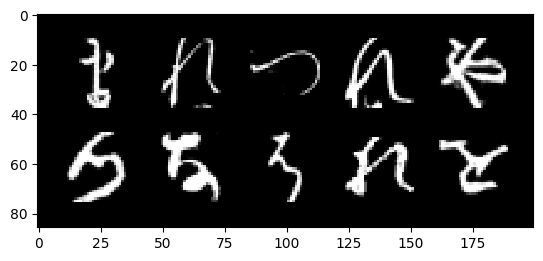

In [58]:
visualize_images(train_dataloader)

In [196]:
#defining the model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.lin1 = nn.Linear(28*28, 100)
        self.lin2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.lin1(x))
        x = self.lin2(x)
        return x


In [254]:
def test_models(models,optimizers,train_dataloader,valid_dataloader):
    # initialize model
    train_losses_all = []
    validate_losses_all = []
    valid_accs_all = []

    for i, (optimizer,mlp) in enumerate(zip(optimizers,models)):
      # train the MLP
      print(f'****** Model {i+1} **************')
      train_losses, valid_losses, valid_accs = fit(
          model=mlp,
          train_dataloader=train_dataloader,
          valid_dataloader=valid_dataloader,
          optimizer=optimizer,
          epochs=20,
          device=DEVICE
      )
      train_losses_all.append(train_losses)
      validate_losses_all.append(valid_losses)
      valid_accs_all.append(valid_accs_all)
      predict(model=mlp, test_dataloader=test_dataloader, device=DEVICE)
    return train_losses_all, validate_losses_all, valid_accs_all


In [200]:
mlp1 = MLP().to(DEVICE)
mlp2 = MLP().to(DEVICE)
mlp3 = MLP().to(DEVICE)
mlp4 = MLP().to(DEVICE)
list_mlp = [mlp1,mlp2,mlp3,mlp4]

list_optimizers = [
    torch.optim.SGD(mlp1.parameters(), lr=0.01),
    torch.optim.SGD(mlp2.parameters(), lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.Adam(mlp3.parameters(), lr=0.01),
    torch.optim.Adam(mlp4.parameters(), lr=1)
]
train_losses_all, validate_losses_all, valid_accs_all = test_models(list_mlp,list_optimizers,train_dataloader,valid_dataloader)

****** Model 1 **************
Epoch 0: Train Loss=2.2701, Validation Loss=2.2302, Validation acc=26.6500
Epoch 1: Train Loss=2.1901, Validation Loss=2.1441, Validation acc=42.3600
Epoch 2: Train Loss=2.0942, Validation Loss=2.0388, Validation acc=49.2700
Epoch 3: Train Loss=1.9798, Validation Loss=1.9175, Validation acc=54.0700
Epoch 4: Train Loss=1.8549, Validation Loss=1.7921, Validation acc=58.4800
Epoch 5: Train Loss=1.7314, Validation Loss=1.6725, Validation acc=62.4100
Epoch 6: Train Loss=1.6162, Validation Loss=1.5631, Validation acc=65.2700
Epoch 7: Train Loss=1.5122, Validation Loss=1.4650, Validation acc=67.2800
Epoch 8: Train Loss=1.4196, Validation Loss=1.3788, Validation acc=68.3900
Epoch 9: Train Loss=1.3386, Validation Loss=1.3035, Validation acc=69.2500
Epoch 10: Train Loss=1.2681, Validation Loss=1.2379, Validation acc=70.1700
Epoch 11: Train Loss=1.2065, Validation Loss=1.1807, Validation acc=70.7900
Epoch 12: Train Loss=1.1522, Validation Loss=1.1303, Validation acc=

In [221]:
def plot_losses(train_losses_all,validate_losses_all,all_in_one=True):
  for i, (train_loss, validate_loss) in enumerate(zip(train_losses_all, validate_losses_all)):
    plt.plot(train_loss, '-*',label = 'train, model ' + str(i+1))
    plt.plot(validate_loss,'-*', label = 'validate, model '+str(i+1))
    if not all_in_one:
      plt.title("Loss progression across epochs")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.semilogy()
      plt.show()
  if all_in_one:
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.semilogy()
    plt.title("Loss progression across epochs")
    plt.show()

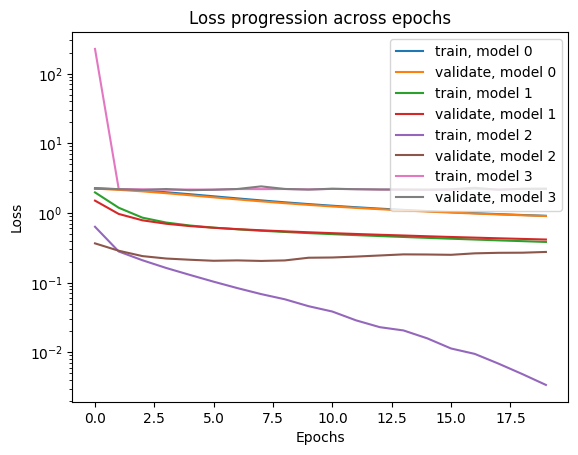

In [202]:
plot_losses(train_losses_all,validate_losses_all)

As it is difficult to see in one single plot, let see in different plots

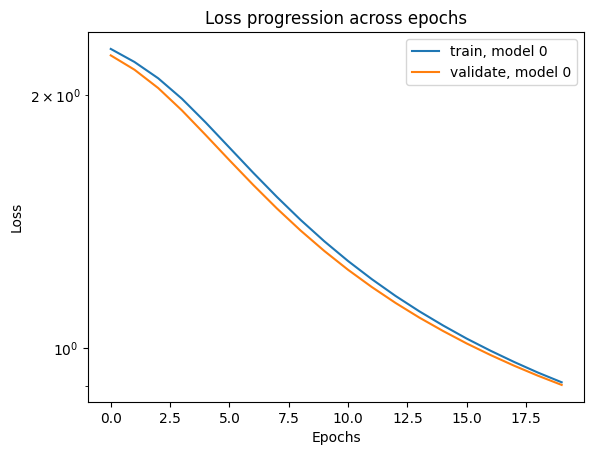

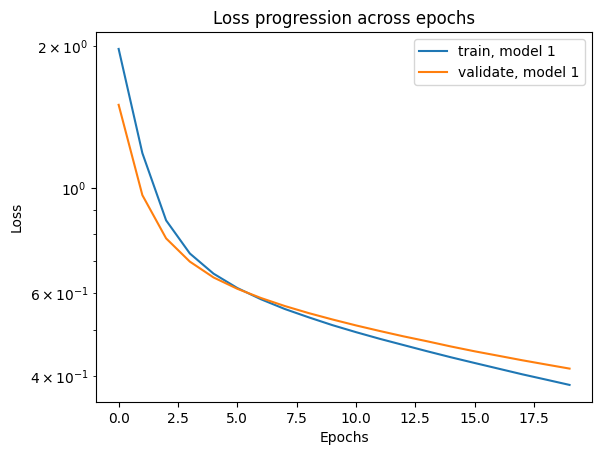

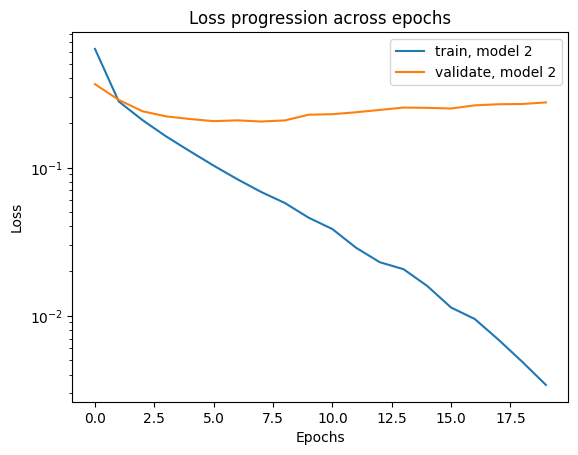

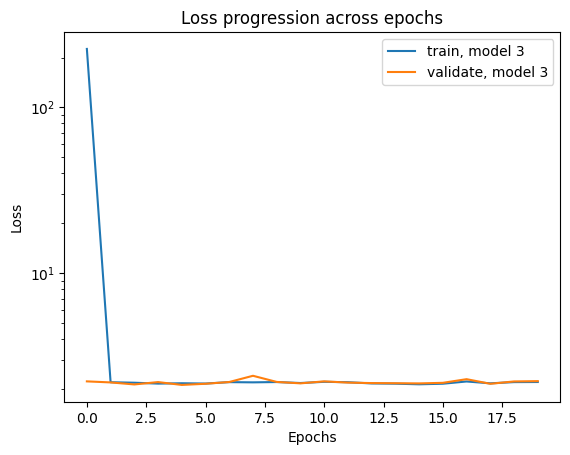

In [203]:
plot_losses(train_losses_all,validate_losses_all,all_in_one=False)

From these three plots, it is possible to draw the following conclusions:
* The SGD optimizer without the momentum converges slower than with the momentum. It is not suprising. As seen in the lecture, adding a momentum can improve the performances.
* The SGD optimizer converges to a solution, but in 20 epochs, it does not achieve the solution, since the loss is still decreasing
* The Adam optimizer with lr=0.01 converges faster than the SGD. In 20 epchos, it already achieves the solution since, there is a plateau in the loss. The accuracy on the validation set is higher than with the SGD.
* The Adam optimizer with lr=1 diverges. The accuracy of the validation set is arround 20\% which is really bad. It can therefore be concluded that a learning rate of 1 is too big for the Adam optimizer.

We should therefore choose the second model to achieve the best performance.

3.

In [204]:
# YOUR CODE HERE
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568,10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x

In [205]:
cnn1 = CNN().to(DEVICE)
cnn2 = CNN().to(DEVICE)
cnn3 = CNN().to(DEVICE)
cnn4 = CNN().to(DEVICE)
list_mlp = [cnn1,cnn2,cnn3,cnn4]

list_optimizers = [
    torch.optim.SGD(cnn1.parameters(), lr=0.01),
    torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.Adam(cnn3.parameters(), lr=0.01),
    torch.optim.Adam(cnn4.parameters(), lr=1)
]
train_losses_all, validate_losses_all, valid_accs_all = test_models(list_mlp,list_optimizers,train_dataloader,valid_dataloader)

****** Model 1 **************
Epoch 0: Train Loss=2.2419, Validation Loss=2.1680, Validation acc=45.0200
Epoch 1: Train Loss=2.0138, Validation Loss=1.7878, Validation acc=59.3800
Epoch 2: Train Loss=1.5129, Validation Loss=1.2804, Validation acc=67.0300
Epoch 3: Train Loss=1.1470, Validation Loss=1.0510, Validation acc=69.5800
Epoch 4: Train Loss=0.9753, Validation Loss=0.9274, Validation acc=72.1700
Epoch 5: Train Loss=0.8783, Validation Loss=0.8555, Validation acc=74.1800
Epoch 6: Train Loss=0.8199, Validation Loss=0.8105, Validation acc=75.6500
Epoch 7: Train Loss=0.7822, Validation Loss=0.7765, Validation acc=76.4100
Epoch 8: Train Loss=0.7537, Validation Loss=0.7546, Validation acc=77.1800
Epoch 9: Train Loss=0.7337, Validation Loss=0.7369, Validation acc=77.5100
Epoch 10: Train Loss=0.7183, Validation Loss=0.7206, Validation acc=77.9800
Epoch 11: Train Loss=0.7005, Validation Loss=0.7087, Validation acc=78.2300
Epoch 12: Train Loss=0.6905, Validation Loss=0.6947, Validation acc=

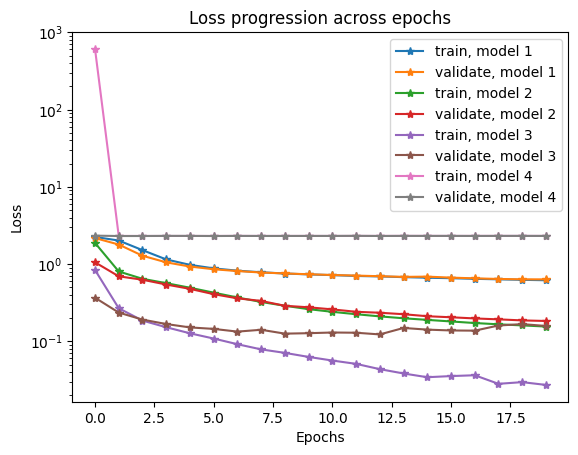

In [222]:
plot_losses(train_losses_all,validate_losses_all,all_in_one=True)

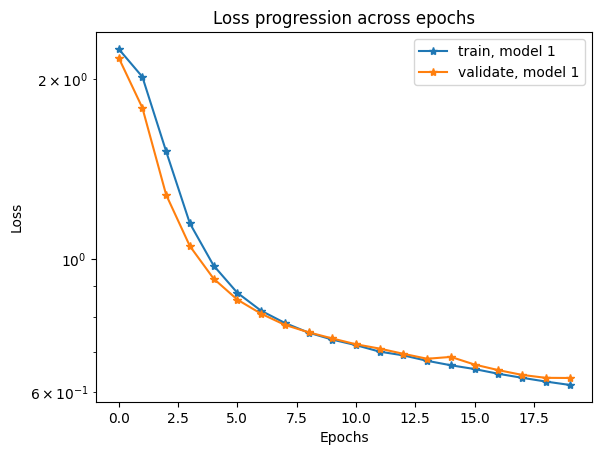

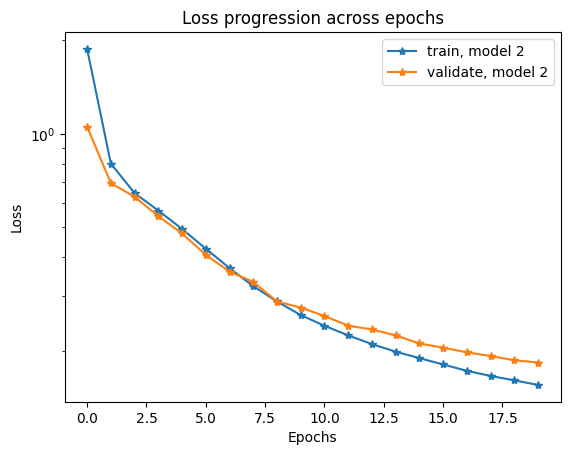

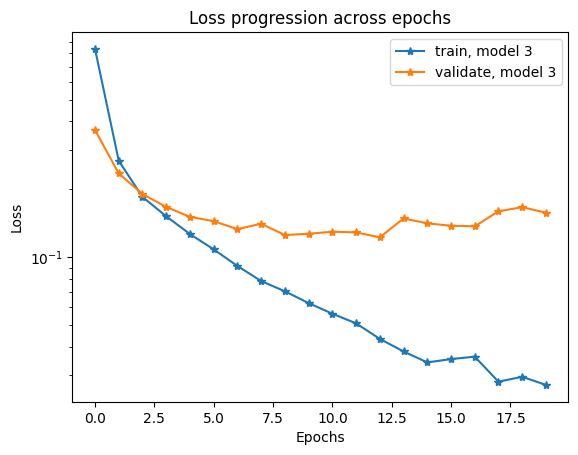

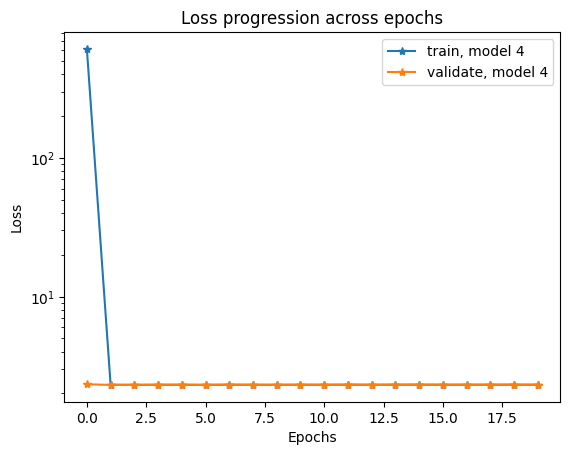

In [223]:
plot_losses(train_losses_all,validate_losses_all,all_in_one=False)

4.

In [224]:
from torchsummary import summary

def compute_nb_param(model):
  total_params = sum(p.numel() for p in model.parameters())
  return total_params

In [225]:
params_cnn = compute_nb_param(CNN())
params_mlp = compute_nb_param(MLP())

print(f'The number of parameters for CNN is : {params_cnn}')
print(f'The number of parameters for MLP is : {params_mlp}')

The number of parameters for CNN is : 20490
The number of parameters for MLP is : 79510


5.

In [246]:
class RandomPermutation(object):
  def __init__(self, num_features):
      self.num_features = num_features
      self.reindex = torch.randperm(num_features)
  def __call__(self, img):
      assert self.num_features == img.numel()
      orig_shape = img.shape
      img = img.view(-1)[self.reindex].view(orig_shape)
      return img

In [255]:
transform = torch.distributions.transforms.ComposeTransform(
    [
        torchvision.transforms.ToTensor(),
        RandomPermutation(28*28)
    ]
)
# load the train dataset
rdn_train_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
rdn_test_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(rdn_train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
rdn_train_dataset,  rdn_valid_dataset = random_split(
    rdn_train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(rdn_train_dataset)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ComposeTransform(
               ToTensor(),
           )


In [256]:
rdn_train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

rdn_valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

rdn_test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

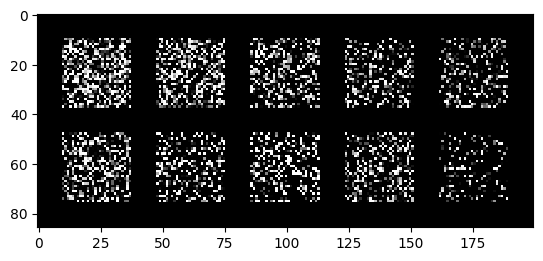

In [257]:
visualize_images(rdn_train_dataloader)

In [258]:
mlp = MLP().to(DEVICE)
cnn = CNN().to(DEVICE)
list_models = [mlp,cnn]

list_optimizers = [
    torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9,nesterov=True),
]
train_losses_all, validate_losses_all, valid_accs_all = test_models(list_models,list_optimizers,rdn_train_dataloader,rdn_valid_dataloader)

****** Model 1 **************
Epoch 0: Train Loss=1.9825, Validation Loss=1.5065, Validation acc=65.9200
Epoch 1: Train Loss=1.1779, Validation Loss=0.9580, Validation acc=73.1300
Epoch 2: Train Loss=0.8460, Validation Loss=0.7773, Validation acc=77.4100
Epoch 3: Train Loss=0.7222, Validation Loss=0.6959, Validation acc=79.3700
Epoch 4: Train Loss=0.6563, Validation Loss=0.6467, Validation acc=80.8100
Epoch 5: Train Loss=0.6128, Validation Loss=0.6133, Validation acc=81.8400
Epoch 6: Train Loss=0.5803, Validation Loss=0.5855, Validation acc=82.7800
Epoch 7: Train Loss=0.5545, Validation Loss=0.5644, Validation acc=83.2800
Epoch 8: Train Loss=0.5318, Validation Loss=0.5452, Validation acc=83.7500
Epoch 9: Train Loss=0.5128, Validation Loss=0.5281, Validation acc=84.2400
Epoch 10: Train Loss=0.4950, Validation Loss=0.5131, Validation acc=84.6300
Epoch 11: Train Loss=0.4790, Validation Loss=0.5013, Validation acc=85.0100
Epoch 12: Train Loss=0.4645, Validation Loss=0.4876, Validation acc=

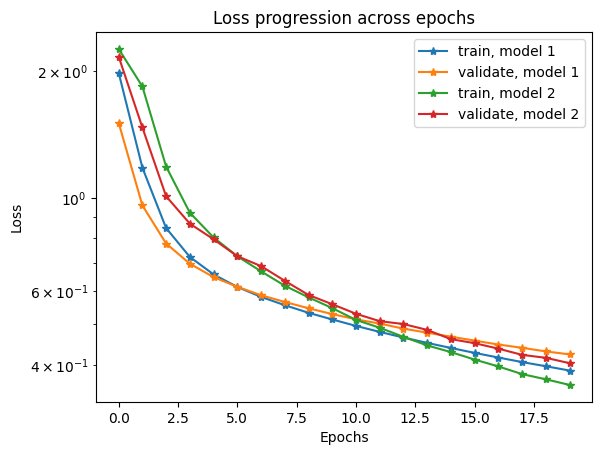

In [259]:
plot_losses(train_losses_all,validate_losses_all,all_in_one=True)

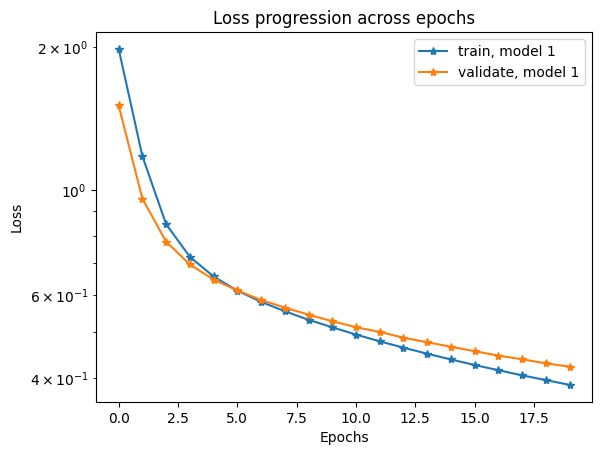

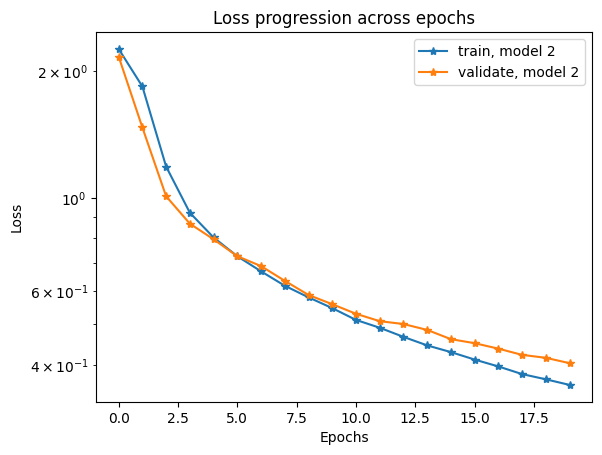

In [260]:
plot_losses(train_losses_all,validate_losses_all,all_in_one=False)